In [2]:
import pandas as pd
from hanziconv import HanziConv
from textdistance import levenshtein, jaccard
import matplotlib.pyplot as plt
%matplotlib inline

## Statistical and Visual Analysis of the Dataset

In [3]:
df = pd.read_csv('data_total.csv', index_col='id_')

In [4]:
without_ukr = df['country'] != 'Ukraine'
df_no_ukr = df[without_ukr]
df_no_ukr.shape

(13410, 9)

## Overview

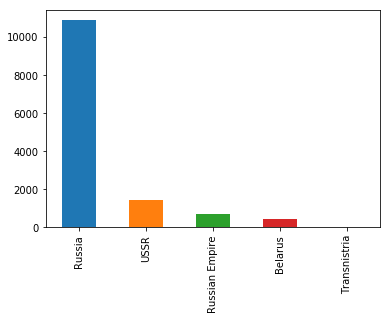

In [6]:
df_no_ukr['country'].value_counts().plot(kind='bar')

Text(0.5,1,'Distribution by Country')

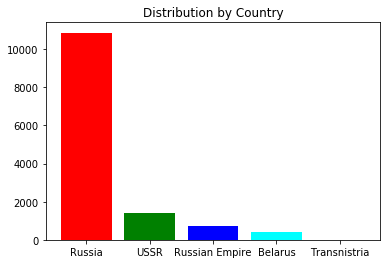

In [17]:
countries = dict(df_no_ukr['country'].value_counts())
countries
plt.bar(countries.keys(), countries.values(), color=['red', 'green', 'blue', 'cyan', 'black'])
plt.title('Distribution by Country')

Text(0.5,1,'Distribution by Type')

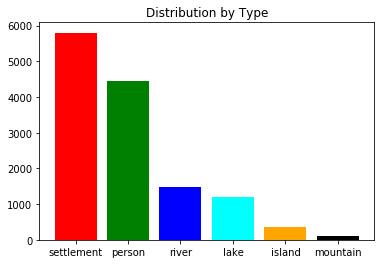

In [20]:
types = dict(df_no_ukr['type'].value_counts())
types
plt.bar(types.keys(), types.values(), color=['red', 'green', 'blue', 'cyan', 'orange', 'black'])
plt.title('Distribution by Type')

In [21]:
df_no_ukr['country'].value_counts(normalize=True)

Russia            0.809843
USSR              0.104996
Russian Empire    0.052349
Belarus           0.032140
Transnistria      0.000671
Name: country, dtype: float64

In [23]:
df_no_ukr['type'].value_counts(normalize=True)

settlement    0.432662
person        0.332513
river         0.111186
lake          0.088665
island        0.026473
mountain      0.008501
Name: type, dtype: float64

Text(0.5,1,'Distribution by Type and Country')

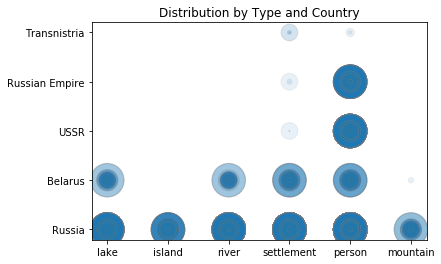

In [29]:
countries=df_no_ukr.country.unique()
types=df_no_ukr.type.unique()
plt.scatter(df_no_ukr['type'],df_no_ukr['country'],s=(df_no_ukr.groupby(['country','type']).size()/5), cmap="Blues", alpha=0.1, edgecolors="grey")
#plt.xticks(types, type_dict.values())
#plt.yticks(countries, countries_dict.values())
plt.title('Distribution by Type and Country')

## Correlation of Xinhua prescriptions and Wikidata: analysis of metrics

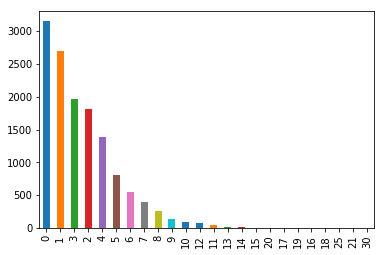

In [25]:
df_no_ukr['levenstein_abs'].value_counts().plot('bar')

In [109]:
df_no_ukr['levenstein_abs'].value_counts(normalize=True)

0     0.236614
1     0.203803
3     0.147427
2     0.137882
4     0.104400
5     0.060254
6     0.039970
7     0.027069
8     0.016629
9     0.008725
10    0.005742
12    0.005295
11    0.002759
13    0.001193
14    0.000820
15    0.000447
17    0.000224
19    0.000149
20    0.000149
16    0.000149
18    0.000075
25    0.000075
21    0.000075
30    0.000075
Name: levenstein_abs, dtype: float64

In [23]:
ukr = df['country'] == 'Ukraine'
df_ukr = df[ukr]
df_ukr.shape

(22840, 9)

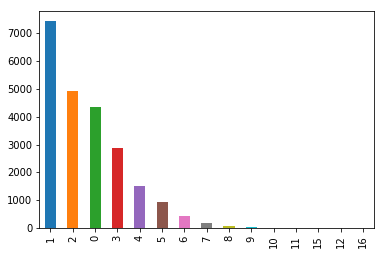

In [24]:
df_ukr['levenstein_abs'].value_counts().plot('bar')

Text(0.5,1,'Mean Absolute Levenstein Distance by Type')

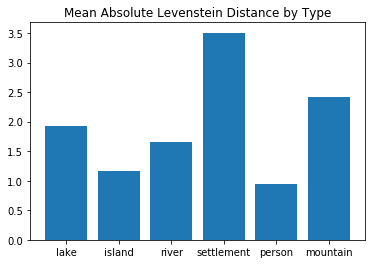

In [32]:
type_mean_lev=df_no_ukr.groupby('type').mean()['levenstein_abs']
types = df_no_ukr.type.unique()
plt.bar(types, type_mean_lev)
#plt.xticks(types, type_dict.values(), rotation=45)
plt.title('Mean Absolute Levenstein Distance by Type')

Text(0.5,1,'Mean Absolute Levenstein Distance by Country')

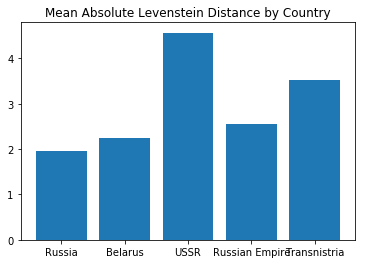

In [34]:
country_mean_lev=df_no_ukr.groupby('country').mean()['levenstein_abs']
countries = df_no_ukr.country.unique()
plt.bar(countries, country_mean_lev)
#plt.xticks(types, type_dict.values(), rotation=45)
plt.title('Mean Absolute Levenstein Distance by Country')

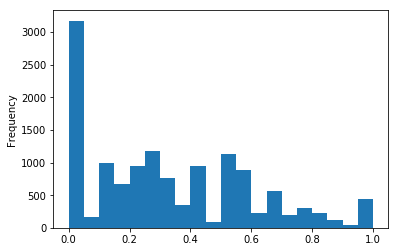

In [50]:
df_no_ukr['levenstein_norm'].plot(kind = 'hist', bins=20)
#lev_norm = dict()
#plt.hist(lev_norm, bins=20)

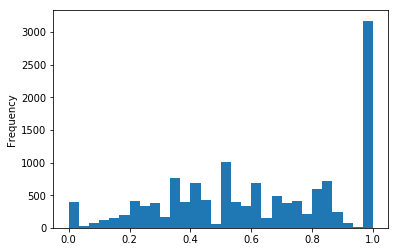

In [108]:
df_no_ukr['jaccard'].plot(kind = 'hist', bins=30)


## Study on partial semantic translation

orientational = верхне-, нижне-, северный, южный, восточный, западный, центральный (and derived roots)

adjectives = большой/великий, малый, старый, новый, черный, белый, красный, зеленый, синий (and derived roots)

morphemes = при-, на-, за-, под-, пред-, -на-

In [69]:
variation_orient, variation_adjectives, variation_morphemes = {}, {}, {}

In [68]:
def geogr_subset(name, regex_ru, regex_zh, d, data=df_no_ukr, no_person=True):
    if no_person == True:
        no_pers = data['type'] != 'person'
        df_ = data[no_pers]
    else:
        df_ = data
    subset = df_[df_['label_ru'].str.contains(regex_ru)]
    subset_zh = subset[subset['label_zh'].str.match(regex_zh)]
    subset_stat = [subset.shape[0], subset_zh.shape[0], subset.shape[0]-subset_zh.shape[0]]
    d[name] = subset_stat
    return subset

In [67]:
orient_data = [['Верх-', '(В| в)ерх', '\A上'], ['Ниж-', '( н|Н)иж', '\A下'],
               ['Центр-', '( ц|Ц)ентр', '\A中'], ['Юж-', '(Ю| ю)жн', '\A南'], ['Север-', '(С| с)евер', '\A北'], 
               ['Восток-', '( в|В)осто(к|ч)', '\A东'], ['Запад-', '(З| з)апад', '\A西']]

In [70]:
for el in orient_data:
    geogr_subset(el[0], el[1], el[2], variation_orient)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


In [71]:
variation_orient

{'Верх-': [80, 53, 27],
 'Ниж-': [58, 48, 10],
 'Центр-': [6, 3, 3],
 'Юж-': [10, 6, 4],
 'Север-': [24, 13, 11],
 'Восток-': [6, 1, 5],
 'Запад-': [7, 4, 3]}

In [72]:
adjective_data = [['Великий', 'Велик(о|ы|а|и)', '\A大'],['Большой', 'Больш(о|е|а|и)', '\A大'], ['Малый', 'Мал(ы|о|а)', '\A小'],
                  ['Старый', '( с|С)тар(о|ы|а)', '\A(旧|古|老)'], ['Новый', 'Нов(о|ы|а|г)', '\A新'], 
                  ['Черный', 'Ч(е|ё)рн(о|а|ы|и)', '\A黑'],['Белый', 'Бел(а|ы|о)', '\A白'],['Красный', 'Красн(ы|о|а)', '\A红'],
                  ['Синий', 'Син(е|ё|я|ь)', '\A(蓝|青)'], ['Зеленый', '(З|з)елен(о|а|ы|е)', '\A(绿|青)']]

In [73]:
for el in adjective_data:
    geogr_subset(el[0], el[1], el[2], variation_adjectives)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


In [74]:
variation_adjectives

{'Великий': [20, 8, 12],
 'Большой': [146, 116, 30],
 'Малый': [70, 52, 18],
 'Старый': [41, 33, 8],
 'Новый': [172, 156, 16],
 'Черный': [28, 2, 26],
 'Белый': [69, 15, 54],
 'Красный': [108, 30, 78],
 'Синий': [6, 1, 5],
 'Зеленый': [8, 0, 8]}

In [75]:
def geogr_subset_morphemes(name, regex_ru, n, d, data=df_no_ukr, no_person=True):
    if no_person == True:
        no_pers = data['type'] != 'person'
        df_ = data[no_pers]
    else:
        df_ = data
    subset = df_[df_['label_ru'].str.contains(regex_ru)]
    subset_zh = list(subset['label_zh'])
    initial_counts = {}
    for zh in subset_zh:
        s = zh[:n]
        if s not in initial_counts:
            initial_counts[s] = 1
        else:
            initial_counts[s] += 1
    #subset_zh = subset[subset['label_zh'].str.match(regex_zh)]
    #subset_stat = [subset.shape[0], subset_zh.shape[0], subset.shape[0]-subset_zh.shape[0]]
    d[name] = initial_counts
    return subset

In [76]:
morpheme_data = [['При-', '(П| п)ри', 2, variation_morphemes], ['На-', '(Н| н)а', 1, variation_morphemes], 
                 ['За-', '(З| з)а', 1, variation_morphemes], ['Под-', '(П| п)од', 2, variation_morphemes],
                ['Пред', '( п|П)ред', 2, variation_morphemes]]

In [77]:
variation_morphemes = {}
for el in morpheme_data:
    geogr_subset_morphemes(el[0], el[1], el[2], variation_morphemes)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


In [78]:
variation_morphemes

{'При-': {'普里': 44, '普尔': 1, '普林': 1, '乌斯': 1, '滨海': 1},
 'На-': {'纳': 67,
  '罗': 1,
  '阿': 3,
  '胡': 1,
  '南': 2,
  '奈': 3,
  '瑙': 2,
  '基': 1,
  '顿': 1,
  '维': 1,
  '哈': 1,
  '涅': 1,
  '拉': 2,
  '卡': 1},
 'За-': {'扎': 90,
  '兔': 1,
  '道': 1,
  '西': 4,
  '赞': 1,
  '达': 1,
  '宰': 2,
  '涅': 2,
  '后': 2,
  '阿': 1,
  '加': 1,
  '彼': 2,
  '戈': 1,
  '藻': 1,
  '佩': 1,
  '莫': 1,
  '纳': 1},
 'Под-': {'通古': 1, '波德': 15, '石泉': 1, '戈拉': 1, '波多': 4},
 'Пред': {'普列': 1}}

#### The last morpheme - hepan

In [79]:
hepan = df[df['label_zh'].str.contains('河畔')]
na_ru = hepan[hepan['label_ru'].str.contains('(Н|н)а')]
hepan_stat = [hepan.shape[0], na_ru.shape[0], hepan.shape[0]-na_ru.shape[0]]
hepan

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,wiki_id,label_zh,label_ru,xinhua,country,type,levenstein_abs,levenstein_norm,jaccard
id_,,,,,,,,,
18781,1347765,顿河畔纳希切万,Нахичевань-на-Дону,纳希切万·纳·多努,Russia,settlement,8,0.888889,0.333333
30053,908,顿河畔罗斯托夫,Ростов-на-Дону,罗斯托夫纳·多努,Russia,settlement,7,0.875000,0.363636
30602,95041,卡马河畔切尔尼,Набережные Челны,娜别列日内耶·切尔内,Russia,settlement,8,0.800000,0.133333
30717,102435,顿河畔卡拉奇,Калач-на-Дону,卡拉奇纳·多努,Russia,settlement,7,1.000000,0.300000
31577,144057,鄂毕河畔卡缅,Камень-на-Оби,卡缅·纳·奥比,Russia,settlement,7,1.000000,0.181818
32249,862107,莫斯科河畔,Замоскворечье,扎莫斯克沃列奇耶,Russia,settlement,6,0.750000,0.181818
32416,4417705,孙扎河畔斯莫夫斯沃,Серноводская,谢尔诺沃茨卡亚,Russia,settlement,9,1.000000,0.066667


### Making visualization
#### Orientational morphemes and adjectives

In [80]:
stackChart_orient=pd.DataFrame.from_dict(variation_orient, orient='index')

In [81]:
stackChart_orient

,0,1,2
Верх-,80,53,27
Ниж-,58,48,10
Центр-,6,3,3
Юж-,10,6,4
Север-,24,13,11
Восток-,6,1,5
Запад-,7,4,3


In [82]:
stackChart_orient.rename(columns={0:'total',1:'zh_absolute', 2:'ru_absolute'}, inplace=True)
stackChart_orient['zh_frac'] = stackChart_orient.apply(lambda row: round(row.zh_absolute / row.total, 2), axis=1)
stackChart_orient['ru_frac'] = stackChart_orient.apply(lambda row: round(row.ru_absolute / row.total, 2), axis=1)
stackChart_orient

,total,zh_absolute,ru_absolute,zh_frac,ru_frac
Верх-,80,53,27,0.66,0.34
Ниж-,58,48,10,0.83,0.17
Центр-,6,3,3,0.50,0.50
Юж-,10,6,4,0.60,0.40
Север-,24,13,11,0.54,0.46
Восток-,6,1,5,0.17,0.83
Запад-,7,4,3,0.57,0.43


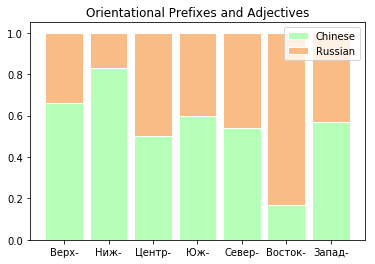

In [88]:
r = [i for i in range(stackChart_orient.shape[0])]
barWidth = 0.85
#names = list(stackChart.index)
# Create green Bars
#labels = 
p1 = plt.bar(r, stackChart_orient['zh_frac'], color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
p2 = plt.bar(r, stackChart_orient['ru_frac'], bottom=stackChart_orient['zh_frac'], 
             color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
#plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, list(stackChart_orient.index))
plt.title("Orientational Prefixes and Adjectives")
plt.legend((p1[0], p2[0]), ('Chinese', 'Russian'))
#plt.yticks(list(stackChart['total']))
# Show graphic
plt.show()
 

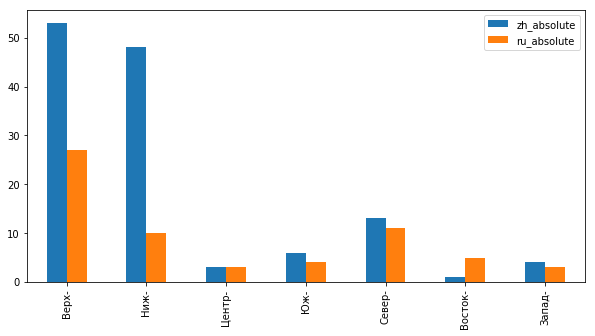

In [84]:
stackChart_orient[['zh_absolute', 'ru_absolute']].plot.bar(figsize=(10,5))

#### Other adjectives and derived morphemes

In [42]:
variation_adjectives

{'veliky': [20, 8, 12],
 'bolshoy': [146, 116, 30],
 'malyy': [70, 52, 18],
 'stary': [41, 33, 8],
 'novy': [172, 156, 16],
 'cherny': [28, 2, 26],
 'bely': [69, 15, 54],
 'krasny': [108, 30, 78],
 'siny': [6, 1, 5],
 'zeleny': [8, 0, 8]}

In [85]:
stackChart_adj=pd.DataFrame.from_dict(variation_adjectives, orient='index')
stackChart_adj.rename(columns={0:'total',1:'zh_absolute', 2:'ru_absolute'}, inplace=True)
stackChart_adj['zh_frac'] = stackChart_adj.apply(lambda row: round(row.zh_absolute / row.total, 2), axis=1)
stackChart_adj['ru_frac'] = stackChart_adj.apply(lambda row: round(row.ru_absolute / row.total, 2), axis=1)
stackChart_adj

,total,zh_absolute,ru_absolute,zh_frac,ru_frac
Великий,20,8,12,0.40,0.60
Большой,146,116,30,0.79,0.21
Малый,70,52,18,0.74,0.26
Старый,41,33,8,0.80,0.20
Новый,172,156,16,0.91,0.09
Черный,28,2,26,0.07,0.93
Белый,69,15,54,0.22,0.78
Красный,108,30,78,0.28,0.72
Синий,6,1,5,0.17,0.83
Зеленый,8,0,8,0.00,1.00


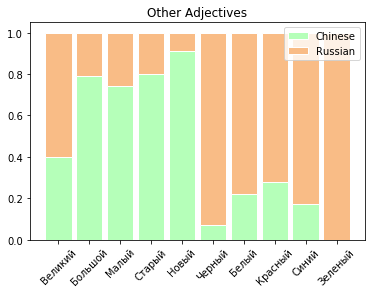

In [87]:
r = [i for i in range(stackChart_adj.shape[0])]
barWidth = 0.85
p1 = plt.bar(r, stackChart_adj['zh_frac'], color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
p2 = plt.bar(r, stackChart_adj['ru_frac'], bottom=stackChart_adj['zh_frac'], 
             color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
 
# Custom x axis
plt.xticks(r, list(stackChart_adj.index), rotation=45)
plt.title("Other Adjectives")
plt.legend((p1[0], p2[0]), ('Chinese', 'Russian'))
# Show graphic
plt.show()
 

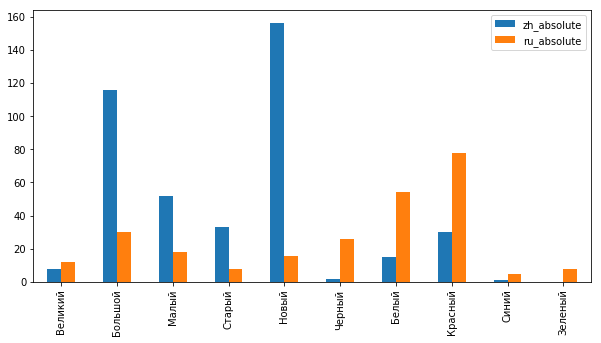

In [89]:
stackChart_adj[['zh_absolute', 'ru_absolute']].plot.bar(figsize=(10,5))

## N-gram analysis

In [92]:
import nltk
from collections import Counter


In [6]:
from nltk.corpus import sinica_treebank

In [40]:
words = sinica_treebank.words()
len(words)

91627

#### we believe that it's not enough 
#### so we made our own reference corpus

In [5]:
with open('reference_corpus.txt', 'r', encoding='utf-8') as src:
    ref_corp = src.read()
import re
ref_corp = re.sub(r'#', r'$', ref_corp)#[。“”：？，！·、\n]
#re.sub(r'#+', r'#', ref_corp)
len(ref_corp)

860379

In [7]:
#raw_xinhua = d['xinhua'].tolist()
#raw_xinhua = '$'.join(raw_xinhua)
from collections import Counter
#text = "This is some text"
bigrams = Counter(x+y+z for x, y, z in zip(*[raw_sents[i:] for i in range(3)]))
for bigram, count in bigrams.most_common(30):
    print (bigram, count)

NameError: name 'raw_sents' is not defined

In [9]:
data_with_spaces = df_no_ukr['label_zh'].tolist()
data_with_spaces = '$'.join(data_with_spaces)
trigrams = Counter(x+y+z for x, y, z in zip(*[data_with_spaces[i:] for i in range(3)]))
for trigram, count in trigrams.most_common(50):
    print (trigram, count)

维奇· 739
夫卡$ 491
斯基$ 466
夫斯$ 434
科耶$ 410
斯克$ 396
亚历山 355
斯科耶 350
$亚历 280
科夫$ 273
历山大 253
诺夫$ 251
耶维奇 242
山大· 231
夫斯基 215
尼古拉 210
米哈伊 200
耶夫$ 189
谢尔盖 185
$谢尔 182
诺耶$ 164
$弗拉 160
洛夫$ 157
诺维奇 154
$尼古 148
拉基米 146
尔盖· 146
弗拉基 145
罗维奇 142
米尔· 137
维奇$ 136
阿列克 132
$米哈 128
洛维奇 128
科夫斯 127
米特里 127
古拉· 127
$阿尔 125
$安德 122
瓦西里 122
基米尔 122
德米特 121
$阿列 118
安德烈 117
罗夫$ 116
尔斯$ 116
列克谢 113
诺夫斯 112
哈伊尔 112
伊尔· 111


In [10]:
data_with_spaces = df_no_ukr['label_zh'].tolist()
data_with_spaces = '$'.join(data_with_spaces)
bigrams = Counter(x+y for x, y in zip(*[data_with_spaces[i:] for i in range(2)]))
for bigram, count in bigrams.most_common(50):
    print (bigram, count)

夫$ 1662
斯$ 1628
维奇 891
夫斯 880
卡$ 792
克$ 765
奇· 760
耶$ 758
$阿 656
基$ 653
尔· 512
斯基 499
夫卡 499
诺夫 484
科夫 482
沃$ 461
斯克 446
斯科 442
$伊 438
科耶 435
耶夫 395
$亚 386
亚历 365
娜· 360
历山 356
$奥 354
娃$ 341
洛夫 330
尔$ 326
尔斯 317
里· 305
$谢 303
$卡 294
罗夫 291
$乌 283
亚$ 283
$克 282
$斯 280
$科 265
诺$ 263
$安 258
$维 256
山大 256
$尼 254
$瓦 248
耶维 244
奇$ 240
谢尔 236
大· 231
$米 222


In [94]:
print(ref_corp[:100])
trigrams_ref = Counter(x+y+z for x, y, z in zip(*[ref_corp[i:] for i in range(3)]))
ref_with_ranks = {}
print(ref_with_ranks)
idx = 1
for t in trigrams_ref.most_common(10000000):
    ref_with_ranks[t[0]]=(t[1], idx)
    idx += 1
data_with_spaces = df_no_ukr['label_zh'].tolist()
data_with_spaces = '$'.join(data_with_spaces)
data_no_spaces = df_no_ukr['label_zh'].tolist()
data_no_spaces = ''.join(data_no_spaces)
trigrams = Counter(x+y+z for x, y, z in zip(*[data_no_spaces[i:] for i in range(3)]))
idx_trigram = 1
x3s, y3s = [], []
for trigram, count in trigrams.most_common(1000):
    if trigram in ref_with_ranks:
        x3s.append(idx_trigram)
        y3s.append(ref_with_ranks[trigram][1])
        print(trigram)
        print('popularity idx = ', str(idx_trigram), ', while in reference corpus popularity idx = ', str(ref_with_ranks[trigram][1]))
    #if bigram in bigrams_ref:
    #    print(bigram, 'is!!!')
    idx_trigram += 1
#print('a')

第一章$青面兽杨志$青面兽杨志碰到张端端$是在老甘的$忻州食府$老甘嗓子坏了$说话用的是气声$说话费劲$还说$杨志就着羊汤$吃完五个烧饼$老甘过来结账$收过钱$坐对面说$旁边五环路$大红门桥$昨天傍晚
{}
拉基米
popularity idx =  12 , while in reference corpus popularity idx =  431333
弗拉基
popularity idx =  14 , while in reference corpus popularity idx =  431332
米尔·
popularity idx =  16 , while in reference corpus popularity idx =  431335
基米尔
popularity idx =  23 , while in reference corpus popularity idx =  431334
安娜·
popularity idx =  88 , while in reference corpus popularity idx =  102345
尔·伊
popularity idx =  233 , while in reference corpus popularity idx =  431336
·伊里
popularity idx =  374 , while in reference corpus popularity idx =  431337
里奇·
popularity idx =  591 , while in reference corpus popularity idx =  431339
奇·列
popularity idx =  702 , while in reference corpus popularity idx =  431340
伊里奇
popularity idx =  705 , while in reference corpus popularity idx =  431338
托尔斯
popularity idx =  756 , while in reference corpus popularity idx =  392538
俄罗斯
popularity idx =  835 , whil

Text(0,0.5,'3-Gram Rank in the Reference Corpus')

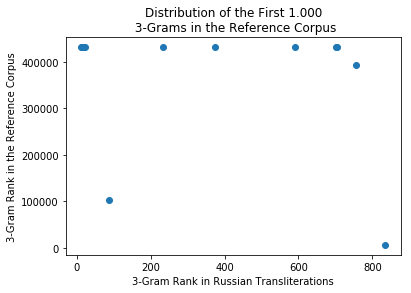

In [95]:
plt.scatter(x3s, y3s)
plt.title('Distribution of the First 1.000\n 3-Grams in the Reference Corpus')
plt.xlabel('3-Gram Rank in Russian Transliterations')
plt.ylabel('3-Gram Rank in the Reference Corpus')

In [115]:
len(xs)

63

In [96]:
data_with_spaces = df_no_ukr['label_zh'].tolist()
data_with_spaces = '$'.join(data_with_spaces)
data_no_spaces = df_no_ukr['label_zh'].tolist()
data_no_spaces = ''.join(data_no_spaces)
bigrams_ref = Counter(x+y for x, y in zip(*[ref_corp[i:] for i in range(2)]))
ref_with_ranks = {}
idx = 1
for b in bigrams_ref.most_common(10000000):
    ref_with_ranks[b[0]]=(b[1], idx)
    idx += 1
bigrams = Counter(x+y for x, y in zip(*[data_no_spaces[i:] for i in range(2)]))
idx_bigram = 1
xs, ys = [], []
for bigram, count in bigrams.most_common(1000):
    if bigram in ref_with_ranks:
        xs.append(idx_bigram)
        print(bigram, ref_with_ranks[bigram][1])
        print('popularity idx = ', str(idx_bigram), ', while in reference corpus popularity idx = ', str(ref_with_ranks[bigram][1]))
        ys.append(ref_with_ranks[bigram][1])
    #if bigram in bigrams_ref:
    #    print(bigram, 'is!!!')
    idx_bigram += 1
    #
    #

奇· 142959
popularity idx =  3 , while in reference corpus popularity idx =  142959
斯基 52103
popularity idx =  4 , while in reference corpus popularity idx =  52103
尔· 142955
popularity idx =  6 , while in reference corpus popularity idx =  142955
娜· 64332
popularity idx =  14 , while in reference corpus popularity idx =  64332
尔斯 133005
popularity idx =  17 , while in reference corpus popularity idx =  133005
山大 109374
popularity idx =  20 , while in reference corpus popularity idx =  109374
尼古 141879
popularity idx =  24 , while in reference corpus popularity idx =  141879
拉· 88096
popularity idx =  26 , while in reference corpus popularity idx =  88096
·阿 145111
popularity idx =  28 , while in reference corpus popularity idx =  145111
米尔 142954
popularity idx =  30 , while in reference corpus popularity idx =  142954
弗拉 142951
popularity idx =  31 , while in reference corpus popularity idx =  142951
利亚 136053
popularity idx =  34 , while in reference corpus popularity idx =  136053
·

Text(0,0.5,'Bigram Rank in the Reference Corpus')

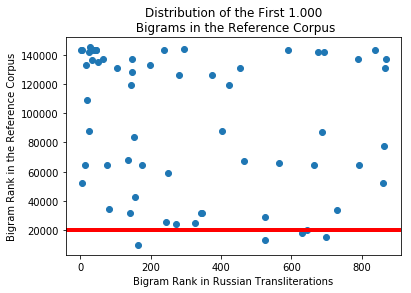

In [100]:
plt.scatter(xs, ys)
plt.axhline(y=20000, linewidth=4, color='r')
plt.title('Distribution of the First 1.000\n Bigrams in the Reference Corpus')
plt.xlabel('Bigram Rank in Russian Transliterations')
plt.ylabel('Bigram Rank in the Reference Corpus')

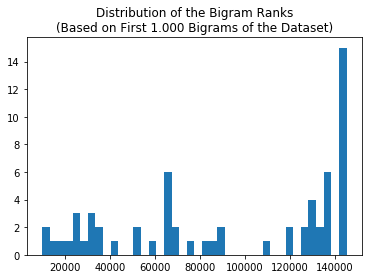

In [123]:
plt.title('Distribution of the Bigram Ranks\n(Based on First 1.000 Bigrams of the Dataset)')
plt.hist(ys, bins=40)
plt.show()

In [79]:
with open('reference_corpus.txt', 'r', encoding='utf-8') as src:
    ref_corp = src.read()
import re
ref_corp = re.sub(r'#', r'$', ref_corp)#[。“”：？，！·、\n]
#re.sub(r'#+', r'#', ref_corp)
len(ref_corp)

860379

In [51]:
ref_corp.count('#')

99403

In [6]:
bigrams_ref = Counter(x+y+z for x, y, z in zip(*[ref_corp[i:] for i in range(3)]))
for bigram, count in bigrams_ref.most_common(200):
    print (bigram, count)

NameError: name 'Counter' is not defined

In [71]:
ref_with_ranks = {}
idx = 1
for b in bigrams_ref.most_common(10000000):
    ref_with_ranks[b[0]]=(b[1], idx)
    idx += 1

In [80]:
len(ref_with_ranks)

440933

In [116]:
data_with_spaces = df_no_ukr['label_zh'].tolist()
data_with_spaces = '$'.join(data_with_spaces)
from collections import Counter
text = "This is some text"
trigrams = Counter(x+y+z for x, y, z in zip(*[data_with_spaces[i:] for i in range(3)]))
for trigram, count in trigrams.most_common(30):
    print (trigram, count)

维奇· 739
夫卡$ 491
斯基$ 466
夫斯$ 434
科耶$ 410
斯克$ 396
亚历山 355
斯科耶 350
$亚历 280
科夫$ 273
历山大 253
诺夫$ 251
耶维奇 242
山大· 231
夫斯基 215
尼古拉 210
米哈伊 200
耶夫$ 189
谢尔盖 185
$谢尔 182
诺耶$ 164
$弗拉 160
洛夫$ 157
诺维奇 154
$尼古 148
拉基米 146
尔盖· 146
弗拉基 145
罗维奇 142
米尔· 137


In [118]:
data_ru = df_no_ukr['label_ru'].tolist()
data_ru = '$'.join(data_ru)
data_ru = data_ru.lower()
from collections import Counter
text = "This is some text"
quadgrams = Counter(x+y+z+a for x, y, z, a in zip(*[data_ru[i:] for i in range(4)]))
for quadgram, count in quadgrams.most_common(30):
    print (quadgram, count)

кий$ 2550
ский 2508
кое$ 2204
ское 2100
овск 1385
вско 937
инск 904
вски 864
нски 834
вич  753
нско 655
ович 583
андр 536
лекс 525
алек 521
$але 421
евск 408
ксан 390
санд 379
нико 379
екса 376
енск 344
ий$к 339
евич 330
анов 319
ова$ 318
ков$ 300
новс 295
ковс 285
ое$к 279


## Character diversity of the dataset

In [112]:
a = list(df_no_ukr['label_zh'])
a = ''.join(a)
b = list(a)
c = set(b)
len(c)

877

In [126]:
df

,Unnamed: 0,wiki_id,label_zh,label_ru,xinhua,country,type,levenstein_abs,levenstein_norm,jaccard
0,0,265997,伊曼德拉,Имандра,伊曼德拉,Russia,lake,0,0.000000,1.000000
1,1,166162,奥涅加,Онежское,奥涅日斯科耶,Russia,lake,4,0.666667,0.285714
2,2,233071,汉泰,Хантайское,汉泰斯科耶,Russia,lake,3,0.600000,0.400000
3,3,245763,奥特拉德诺耶,Отрадное,奥特拉德诺耶,Russia,lake,0,0.000000,1.000000
4,4,117036,绍托泽罗,Шотозеро,绍托泽罗,Russia,lake,0,0.000000,1.000000
5,5,143785,克烈季,Кереть,克列季,Russia,lake,1,0.333333,0.500000
6,6,1280250,尼季利,Недели,涅杰莉,Russia,lake,3,1.000000,0.000000
7,7,1286772,奎托,Куйто,奎托,Russia,lake,0,0.000000,1.000000
8,8,1265476,斯维季亚济,Свитязь,斯维佳济,Ukraine,lake,2,0.400000,0.500000
9,9,5513,贝加尔,Байкал,拜卡尔,Russia,lake,2,0.666667,0.200000


In [113]:
a2 = list(df_no_ukr['xinhua'])
a2 = ''.join(a2)
b2 = list(a2)
c2 = set(b2)
len(c2)

260

## Classificator statistics

In [52]:
classificator_data = [['isles', r'岛$'], ['lakes', r'湖$'], ['mountains', r'山$'], 
                      ['rivers', r'河$'], ['settlements', r'(市镇?|区)$']]

In [53]:
def classificator_stat(t, reg):
    filename = t + '_not_preprocessed.tsv'
    dataset = pd.read_csv(filename, delimiter='\t')
    dataset['label_zh'] = dataset['label_zh'].apply(lambda x: HanziConv.toSimplified(x))
    dataset_shape = dataset.shape[0]
    subset = dataset[dataset['label_zh'].str.contains(reg)]
    subset_shape = subset.shape[0]
    return dataset_shape, subset_shape

In [54]:
classificator_statistics = {}
for c in classificator_data:
    type_, reg_ = c[0], c[1]
    stats = classificator_stat(type_, reg_)
    classificator_statistics[type_] = stats

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [55]:
classificator_stat('isles', r'岛$')

(361, 340)

In [56]:
classificator_statistics

{'isles': (361, 340),
 'lakes': (1261, 1154),
 'mountains': (119, 106),
 'rivers': (2293, 2278),
 'settlements': (27981, 2215)}

In [57]:
class_stat = pd.DataFrame.from_dict(classificator_statistics, orient='index')

In [58]:
class_stat.rename(columns={0:'total',1:'classificator'}, inplace=True)
class_stat['zh_frac'] = class_stat.apply(lambda row: round(row.classificator / row.total, 2), axis=1)
class_stat['zero_frac'] = class_stat.apply(lambda row: round((row.total - row.classificator) / row.total, 2), axis=1)
class_stat

,total,classificator,zh_frac,zero_frac
isles,361,340,0.94,0.06
lakes,1261,1154,0.92,0.08
mountains,119,106,0.89,0.11
rivers,2293,2278,0.99,0.01
settlements,27981,2215,0.08,0.92


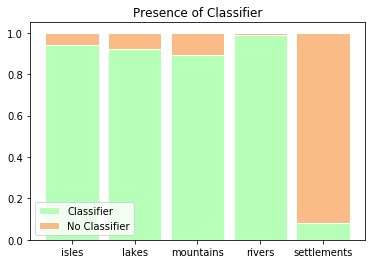

In [60]:
r = [i for i in range(class_stat.shape[0])]
barWidth = 0.85
p1 = plt.bar(r, class_stat['zh_frac'], color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
p2 = plt.bar(r, class_stat['zero_frac'], bottom=class_stat['zh_frac'], 
             color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
 
# Custom x axis
plt.xticks(r, list(class_stat.index))
plt.title("Presence of Classifier")
plt.legend((p1[0], p2[0]), ('Classifier', 'No Classifier'))
# Show graphic
plt.show()
 

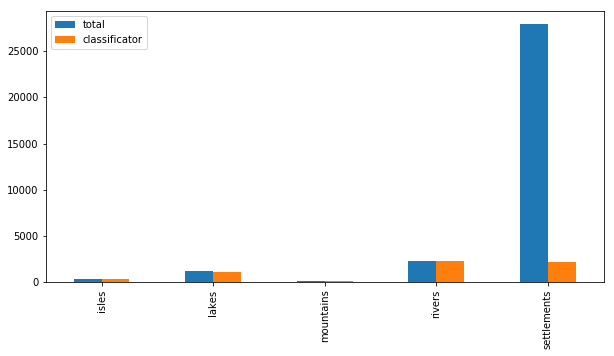

In [25]:
class_stat[['total', 'classificator']].plot.bar(figsize=(10,5))

#### We hope that in the fieldwork we will be able to use the classificators for humans as well - they will be mostly the analogues of "Mister", "Miss" etc.